In [1]:
%reload_ext autoreload
%autoreload 2

### Maximum Monthly Mean climatology
NOAA description [here](https://coralreefwatch.noaa.gov/product/5km/tutorial/crw06a_climatology.php):
> We then defined the Maximum Monthly Mean (MMM) SST climatology. This is the warmest of the 12 monthly mean SST climatology values for each satellite pixel around the world, indicating the upper limit of "usual" temperature.

N.B. for larger datasets (the whole world) will be more efficient to extract points for each timeseries before computing metrics. But wouldn't be able to visualise the whole spatial distribution.

In [72]:
# lazy load sst
import xarray as xa
import numpy as np
import matplotlib.pyplot as plt

from bleachbench.utils import config, utils
from bleachbench.plotting import spatial

In [ ]:
sst_fps = config.crw_sst_dir.glob("*.nc")
ssts_ds = xa.open_mfdataset(sst_fps, chunks={"time": 12})
# efficiently calculate the maximum of monthly means SST climatology: the warmest of the 12 monthly mean SST climatology values for each latitude/longitude pixel
monthly_clim = ssts_ds["CRW_SST"].groupby("time.month").mean("time", skipna=True)
mmm = monthly_clim.max("month")

# mask each month's field where it's equal to the max
is_max = monthly_clim == mmm
month_of_mmm = (is_max * monthly_clim["month"]).max("month")
month_of_mmm = month_of_mmm.where(monthly_clim.notnull().any("month"))

In [49]:
month_of_mmm = month_of_mmm.compute()
mmm = mmm.compute()

/var/folders/tp/x_9dbyf149d6kw_k79l_kk4m0000gq/T/ipykernel_69729/3726242548.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Reds", 12)


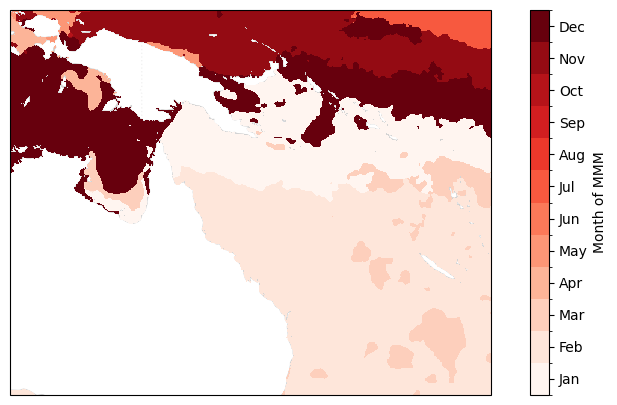

In [78]:
import matplotlib.colors as mcolors
import calendar

cmap = plt.cm.get_cmap("Reds", 12)
norm = mcolors.BoundaryNorm(np.arange(0.5, 13.5, 1), cmap.N)
month_labels = [calendar.month_name[i][:3] for i in range(1, 13)]

fig, ax = plt.subplots(
    1, 1, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(10, 5)
)
p = month_of_mmm.plot(
    ax=ax,
    cmap=cmap,
    norm=norm,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={
        "ticks": np.arange(1, 13),
        "label": "Month of MMM",
    },
)

# replace tick labels with month names
p.colorbar.ax.set_yticklabels(month_labels)
spatial.format_geo_axes(
    ax,
    extent=(
        *utils.get_bounds(month_of_mmm, "longitude"),
        *utils.get_bounds(month_of_mmm, "latitude"),
    ),
)
plt.show()
